# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

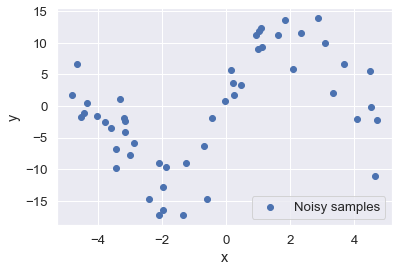

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

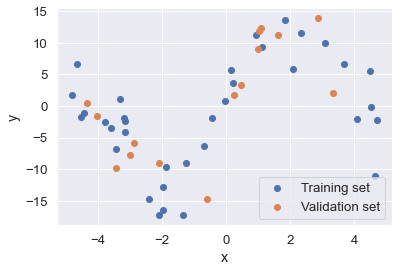

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [111]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

from IPython.display import display

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

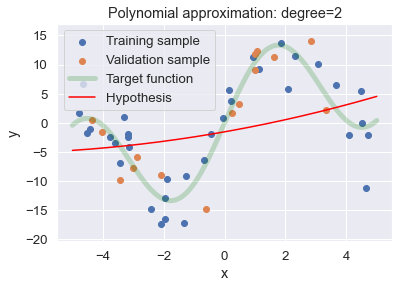

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

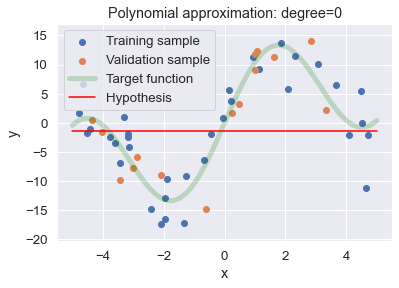

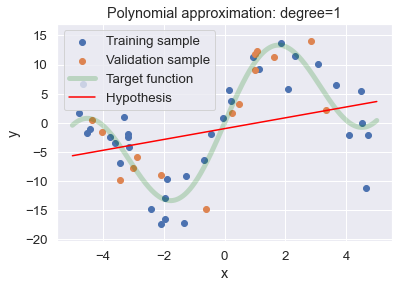

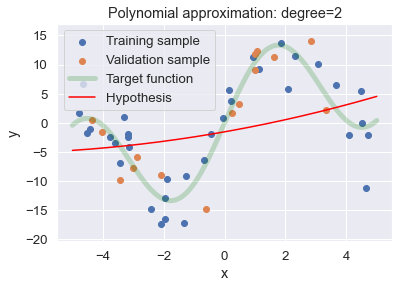

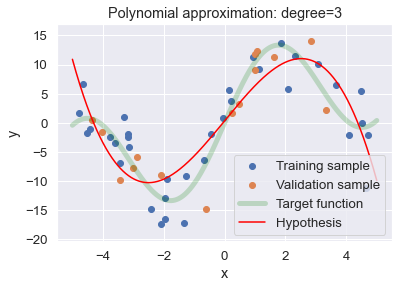

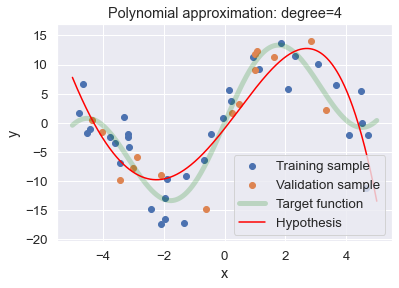

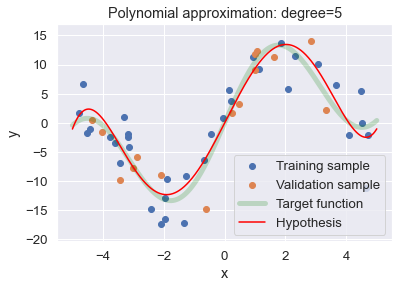

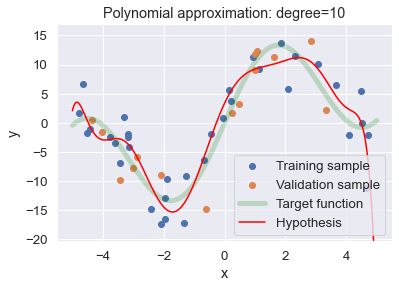

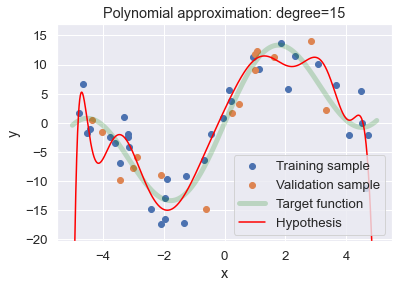

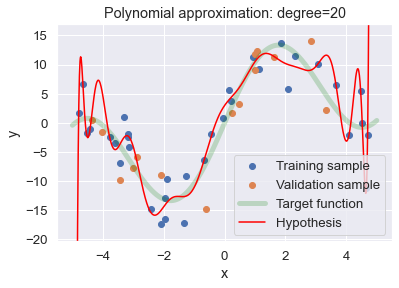

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

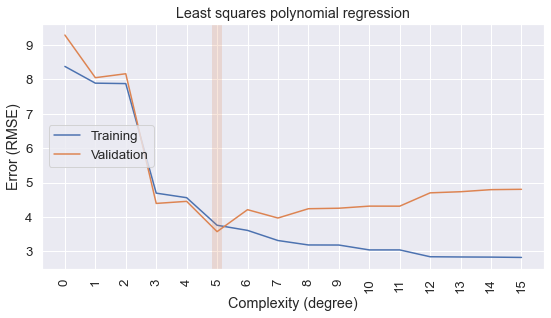

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

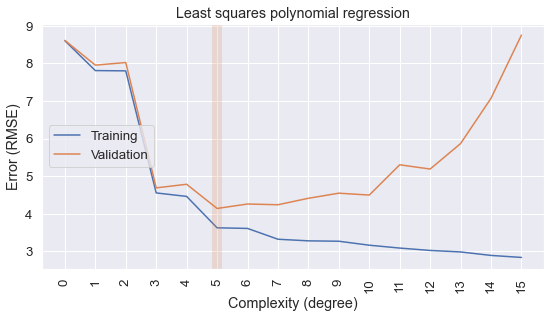

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

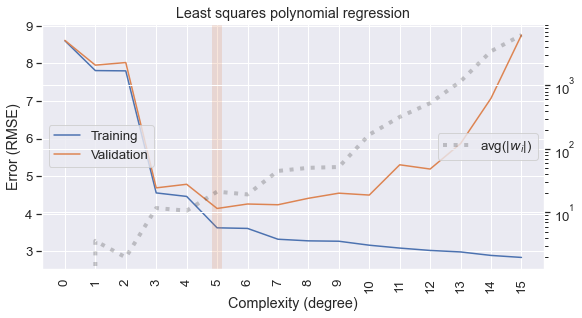

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

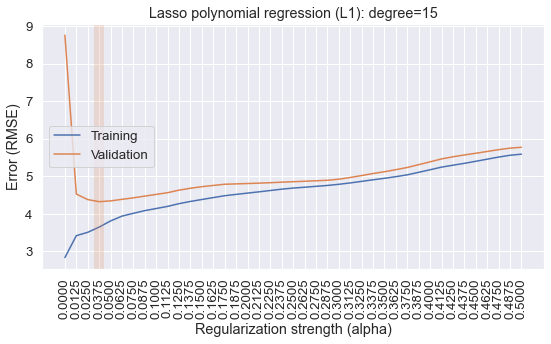

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

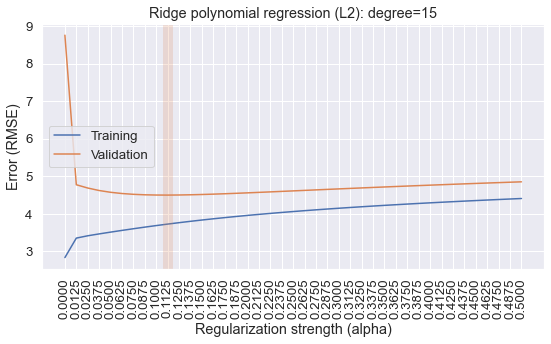

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
#print(data['DESCR'])

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


<AxesSubplot:>

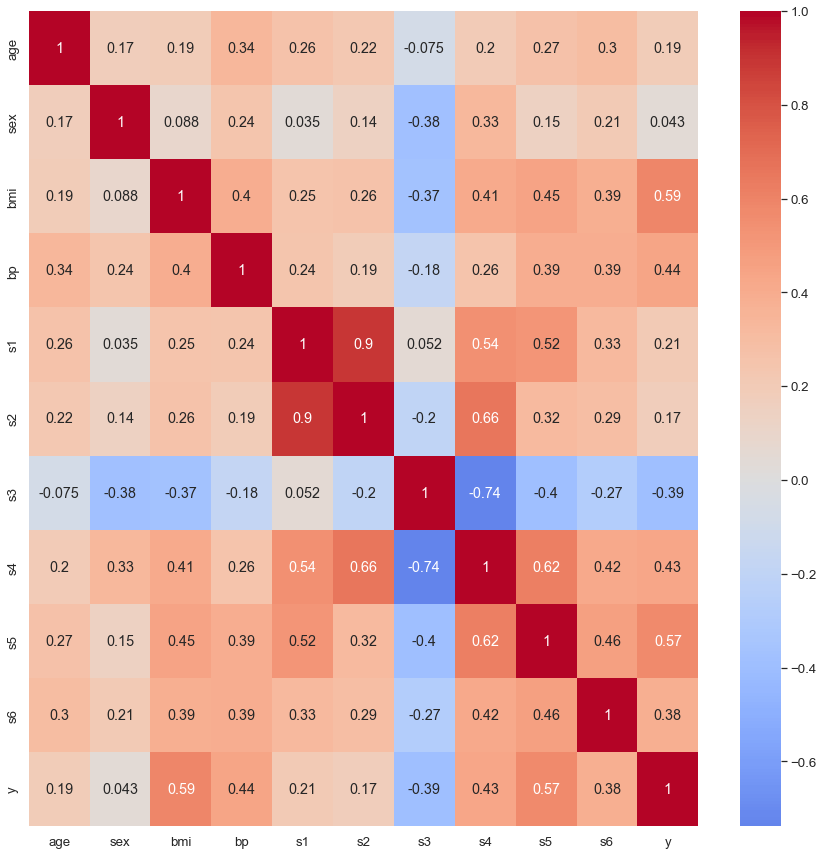

In [21]:
# Со всеми признаками полином 15 степени не рассчитывает. Поэтому отберем наиболее коррелируемые с целевой переменной.
# для этого построим матрицу корреляции

X_diab_corr = X_diabetes.copy()
X_diab_corr['y'] = y_diabetes

correlation_matrix = X_diab_corr.corr()
display(correlation_matrix)
plt.figure(figsize = (15,15))
sns.heatmap(correlation_matrix, annot=True, center=0., cmap='coolwarm')



In [45]:
# Слабо коррелируют с целефой переменной признаки 'age', 'sex', 's1', 's2', 's6' 
# итого остается 6 признаков

X_diabetes_last = X_diabetes.drop(['age', 'sex', 's1', 's2'], axis=1).copy()
X_diabetes_last

,bmi,bp,s3,s4,s5,s6
0,0.061696,0.021872,-0.043401,-0.002592,0.019908,-0.017646
1,-0.051474,-0.026328,0.074412,-0.039493,-0.068330,-0.092204
2,0.044451,-0.005671,-0.032356,-0.002592,0.002864,-0.025930
3,-0.011595,-0.036656,-0.036038,0.034309,0.022692,-0.009362
4,-0.036385,0.021872,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...
437,0.019662,0.059744,-0.028674,-0.002592,0.031193,0.007207
438,-0.015906,-0.067642,-0.028674,0.034309,-0.018118,0.044485
439,-0.015906,0.017282,-0.024993,-0.011080,-0.046879,0.015491
440,0.039062,0.001215,-0.028674,0.026560,0.044528,-0.025930


##### В дальнейшем мы будем использовать при обучении модели набор из 6-ти признаков, отобранных выше

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [46]:
# your findings/conclusions
from sklearn.preprocessing import PolynomialFeatures

# Делим данные на тренировочные и проверочные 70 к 30

X_train_diabed, X_valid_diabed, y_train_diabed, y_valid_diabed = train_test_split(X_diabetes_last, y_diabetes, test_size=0.3, random_state=SEED)


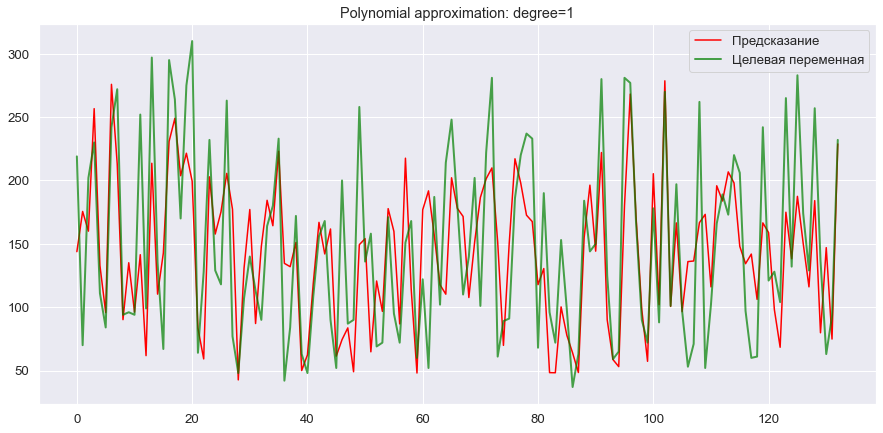

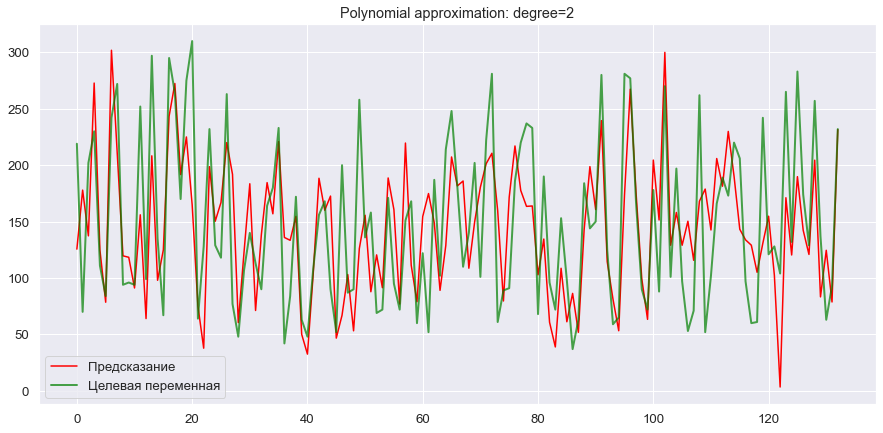

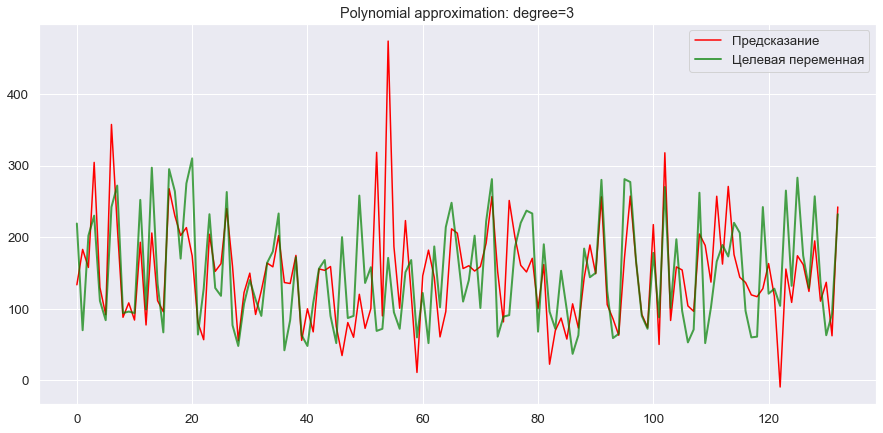

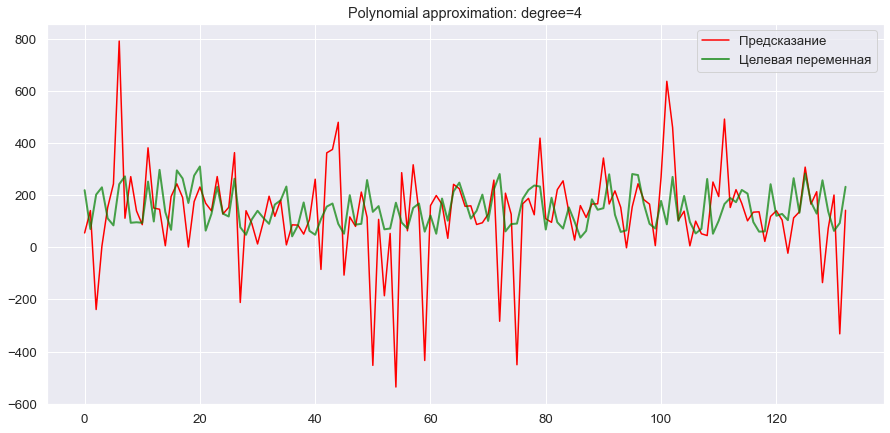

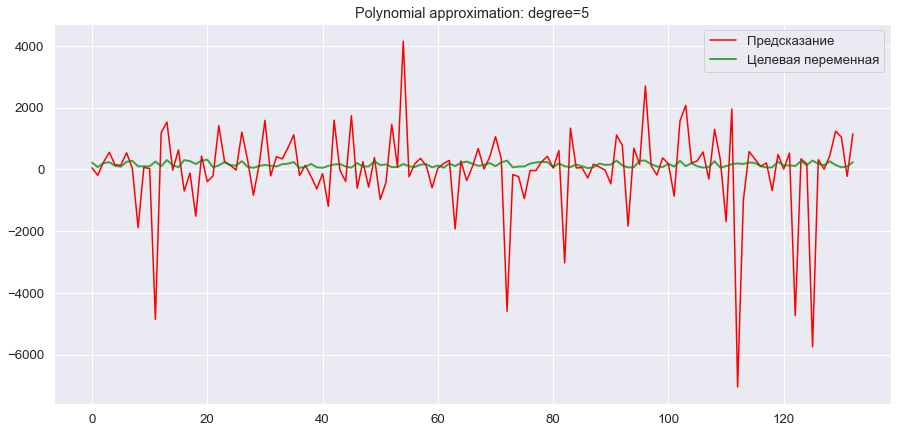

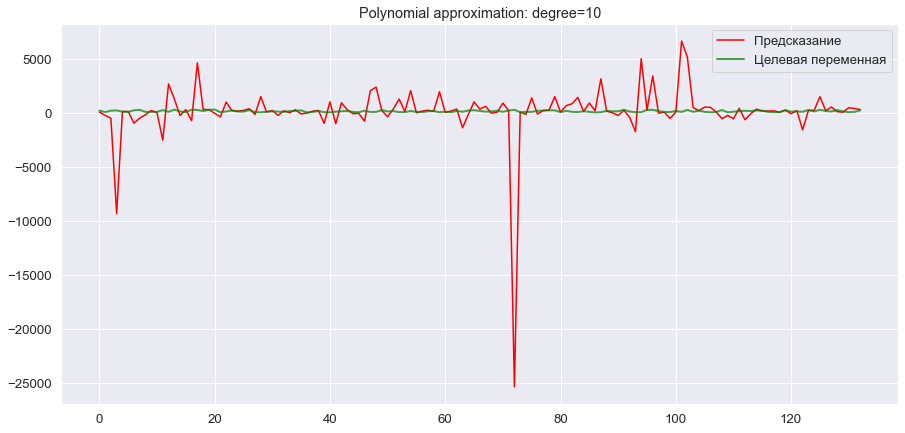

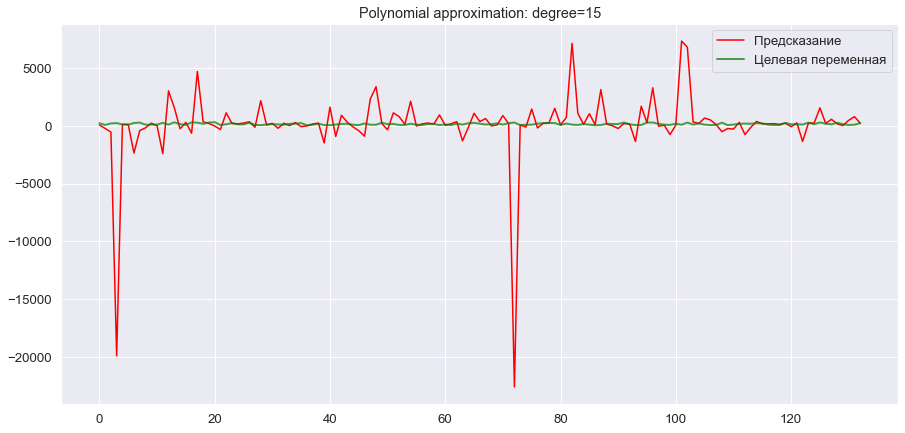

In [47]:

# poly_reg = PolynomialFeatures(degree=1, include_bias=(degree == 0))
# X_poly_train = poly_reg.fit_transform(X_train_diabed)
# X_poly_valid = poly_reg.fit_transform(X_valid_diabed)
for degrey in [1, 2, 3, 4, 5, 10, 15]:
    y_predict_diabed = make_model(degree= degrey).fit(X_train_diabed, y_train_diabed).predict(X_valid_diabed)
    plt.figure(figsize=(15, 7))
    plt.plot(y_predict_diabed, c='red', label='Предсказание')
    plt.plot(y_valid_diabed.to_numpy(), c='green', alpha=0.7, lw=2, label='Целевая переменная')
    plt.legend(loc='best')
    plt.title(f'Polynomial approximation: degree={degrey}')
    plt.show()
    

#### Все что выше 3-й степени наблюдаются очень большие ошибки. 

<Figure size 1080x504 with 0 Axes>

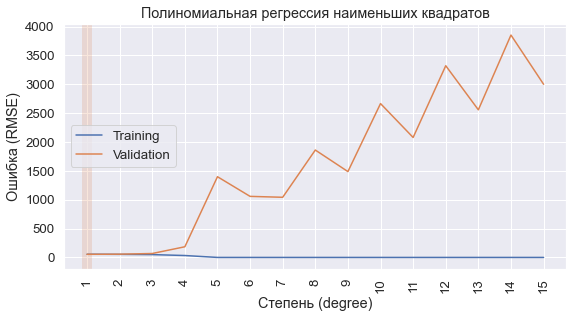

In [48]:
rmse_train_1, rmse_valid_1 = [], []
for degree in np.linspace(1, 15, 15, dtype=int):
    reg_1 = make_model(degree).fit(X_train_diabed, y_train_diabed)
    rmse_train_1.append(rmse(reg_1.predict(X_train_diabed), y_train_diabed))
    rmse_valid_1.append(rmse(reg_1.predict(X_valid_diabed), y_valid_diabed))
plt.figure(figsize=(15, 7))
plot_fitting_graph(np.linspace(1, 15, 15, dtype=int), rmse_train_1, rmse_valid_1, xlabel='Степень (degree)', ylabel='Ошибка (RMSE)', 
                   title='Полиномиальная регрессия наименьших квадратов')

#### Кривая обучения также показывает, что после 3-й степени увеличивается ошибка прогноза. Для уменьшения ошибок нужно вводить регуляризацию.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

  2%|▏         | 1/41 [00:00<00:13,  2.89it/s]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.588e+04, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
  5%|▍         | 2/41 [00:59<22:41, 34.91s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.974e+03, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
  7%|▋         | 3/41 [01:58<28:57, 45.73s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the nu

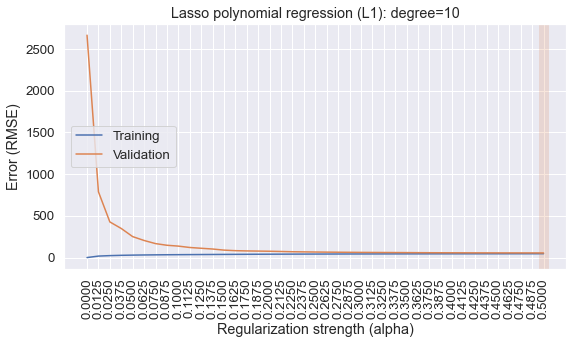

In [237]:
## your code
# poly_reg = PolynomialFeatures(degree=1, include_bias=(degree == 0))
# X_poly_train = poly_reg.fit_transform(X_train_diabed)
# X_poly_valid = poly_reg.fit_transform(X_valid_diabed)
from tqdm import tqdm
degr = 10
rmse_train_L1, rmse_valid_L1, avg_coef_L1 = [], [], []
for alpha in tqdm(ALPHAS):    
    results_L1 = make_model(degree= degr, penalty='L1', alpha=alpha).fit(X_train_diabed, y_train_diabed) 
                            
    rmse_train_L1.append(rmse(results_L1.predict(X_train_diabed), y_train_diabed))
    rmse_valid_L1.append(rmse(results_L1.predict(X_valid_diabed), y_valid_diabed))
    avg_coef_L1.append(
    np.mean([            
            np.mean(np.abs(results_L1['reg'].coef_))
        ]))
    # rmse_train_L1.append(-np.mean(results_L1['train_score'], dtype=np.float64))
    # rmse_valid_L1.append(-np.mean(results_L1['test_score'], dtype=np.float64))
    
plot_fitting_graph(ALPHAS, rmse_train_L1, rmse_valid_L1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title=f'Lasso polynomial regression (L1): degree={degr}')

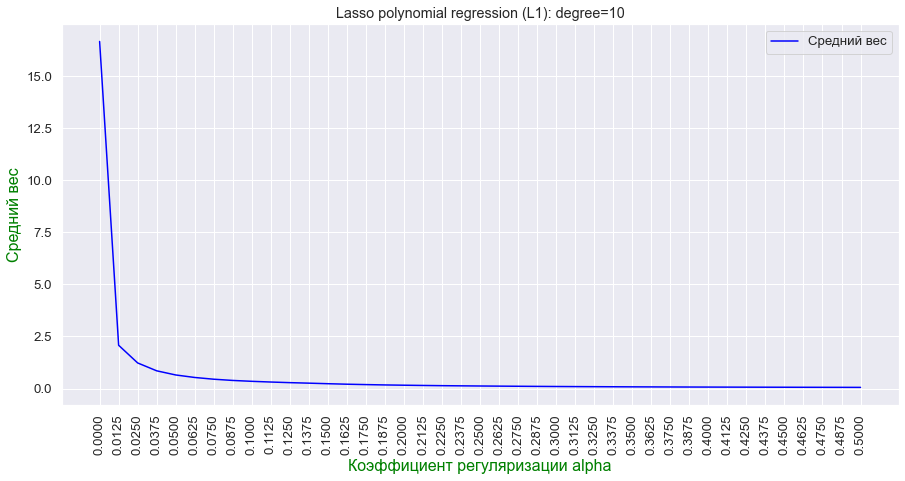

In [262]:
plt.figure(figsize=(15, 7))
plt.plot(ALPHAS, avg_coef_L1, c='blue', label='Средний вес')
#plt.axvline(ALPHAS[np.argmin(avg_coef_L1)], color='C1', lw=10, alpha=0.2)
plt.xticks(ALPHAS, rotation='vertical')
plt.xlabel('Коэффициент регуляризации alpha', fontsize=16, color='green')
plt.ylabel('Средний вес', fontsize=16, color='green')
plt.legend(loc='best')
plt.title(f'Lasso polynomial regression (L1): degree={degr}')
plt.show()

#### Кривая обучения с использованием Lasso-регрессии с L1 - регуляризатором alpha, степень полинома 10-я. Видно,что с увеличением коэффициента регуляризации кривые обучения и прогноза сходятся. Весовые коэффициенты при этом уменьшаются от больших весов при 0-м коэффициенте до минимума. 
#### При построении данного графика не использовалась кросс-валидация. График с использованием кросс-валидации следующий.

C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.189e+04, tolerance: 2.153e+02
  model = cd_fast.enet_coordinate_descent(
C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.775e+04, tolerance: 2.044e+02
  model = cd_fast.enet_coordinate_descent(
C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+04, tolerance: 2.070e+02
  

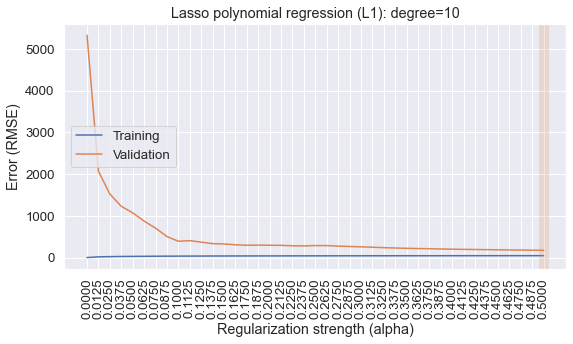

In [50]:
## your code
# poly_reg = PolynomialFeatures(degree=1, include_bias=(degree == 0))
# X_poly_train = poly_reg.fit_transform(X_train_diabed)
# X_poly_valid = poly_reg.fit_transform(X_valid_diabed)
from tqdm import tqdm
degr = 10
rmse_train_L1, rmse_valid_L1 = [], []
for alpha in tqdm(ALPHAS):    
    results_L1 = cross_validate(make_model(degree= degr, penalty='L1', alpha=alpha), 
                             X_diabetes_last, y_diabetes, 
                             cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    
    # rmse_train_L1.append(rmse(results_L1.predict(X_poly_train), y_train_diabed))
    # rmse_valid_L1.append(rmse(results_L1.predict(X_poly_valid), y_valid_diabed))
    rmse_train_L1.append(-np.mean(results_L1['train_score'], dtype=np.float64))
    rmse_valid_L1.append(-np.mean(results_L1['test_score'], dtype=np.float64))
    
plot_fitting_graph(ALPHAS, rmse_train_L1, rmse_valid_L1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title=f'Lasso polynomial regression (L1): degree={degr}')

#### Данный график повторяет предыдущий, за исключением того, что кривые не сошлись. Возможно из-за того, что при кроссвалидации используется больший объем данных для обучения и тестирования.
#### При использовании кросс-валидации время работы с набором данных значительно увеличивается, в нашем случае в 6 раз. 

#### L2

100%|██████████| 41/41 [02:08<00:00,  3.14s/it]


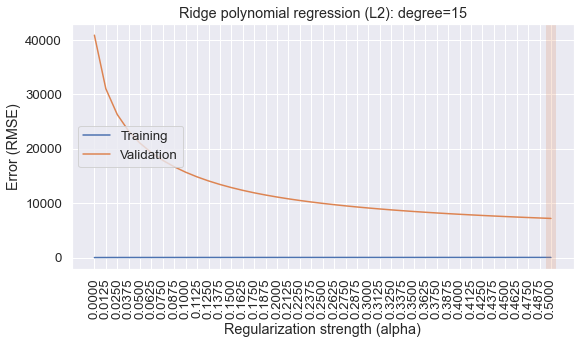

In [263]:
## your code
from tqdm import tqdm
degr = 15
rmse_train_L2, rmse_valid_L2, avg_coef_L2= [], [], []
for alpha in tqdm(ALPHAS):    
    results_L2 = cross_validate(make_model(degree= degr, penalty='L2', alpha=alpha), 
                             X_diabetes_last, y_diabetes, 
                             cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_L2.append(-np.mean(results_L2['train_score']))
    rmse_valid_L2.append(-np.mean(results_L2['test_score']))
    avg_coef_L2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results_L2['estimator']
        ]))


plot_fitting_graph(ALPHAS, rmse_train_L2, rmse_valid_L2, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title=f'Ridge polynomial regression (L2): degree={degr}')

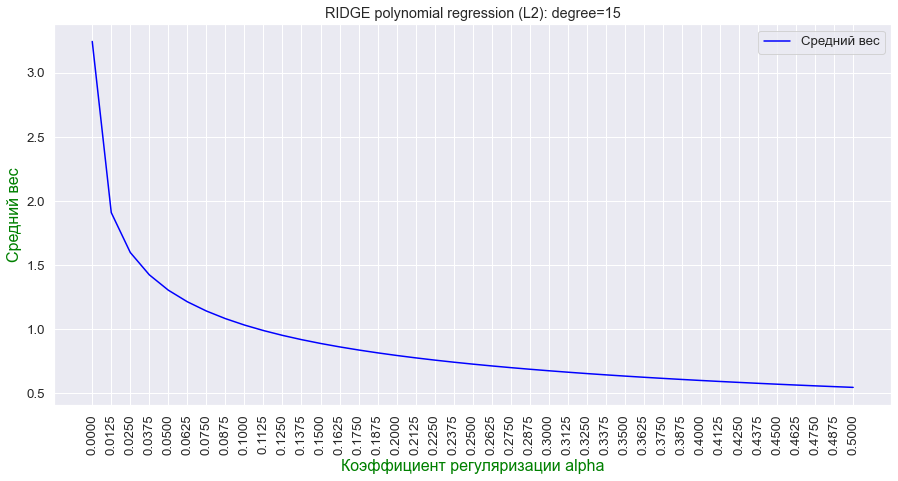

In [264]:
plt.figure(figsize=(15, 7))
plt.plot(ALPHAS, avg_coef_L2, c='blue', label='Средний вес')
#plt.axvline(ALPHAS[np.argmin(avg_coef_L1)], color='C1', lw=10, alpha=0.2)
plt.xticks(ALPHAS, rotation='vertical')
plt.xlabel('Коэффициент регуляризации alpha', fontsize=16, color='green')
plt.ylabel('Средний вес', fontsize=16, color='green')
plt.legend(loc='best')
plt.title(f'RIDGE polynomial regression (L2): degree={degr}')
plt.show()

100%|██████████| 41/41 [00:23<00:00,  1.76it/s]


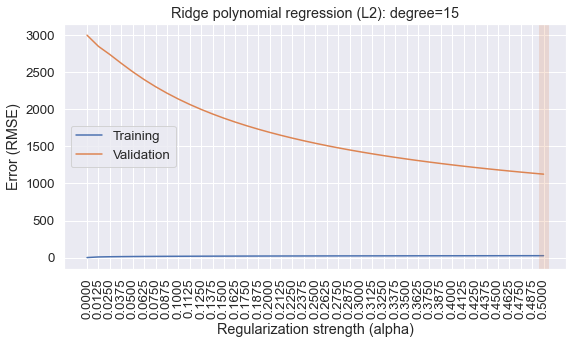

In [265]:
from tqdm import tqdm
degr = 15
rmse_train_L2, rmse_valid_L2 = [], []
for alpha in tqdm(ALPHAS):    
    results_L2 = make_model(degree= degr, penalty='L2', alpha=alpha).fit(X_train_diabed, y_train_diabed) 
                             
    rmse_train_L2.append(rmse(results_L2.predict(X_train_diabed), y_train_diabed))
    rmse_valid_L2.append(rmse(results_L2.predict(X_valid_diabed), y_valid_diabed))
    
plot_fitting_graph(ALPHAS, rmse_train_L2, rmse_valid_L2, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title=f'Ridge polynomial regression (L2): degree={degr}')

#### При использовании гребневой регрессии кривые обучения сходятся медленнее. Весовые коэффициенты уменьшаются медленнее.

#### Summary

* При использовании гребневой регрессии с регуляризацией L2 или Lasso-регрессии с регуляризацией L1 с увеличением коэффициента регуляризации уменьшаются веса признаков.
* Таким образом можно утверждать, что Lasso-регрессия и Ridge-регрессия ограничивают веса признаков. Чем больше коэффициент регуляризации тем меньше вес признака.

In [30]:
## your observations/conclusions

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

  2%|▏         | 1/41 [00:02<01:32,  2.32s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+04, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
  5%|▍         | 2/41 [10:08<3:52:24, 357.54s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.977e+03, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
  7%|▋         | 3/41 [20:15<4:58:37, 471.51s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

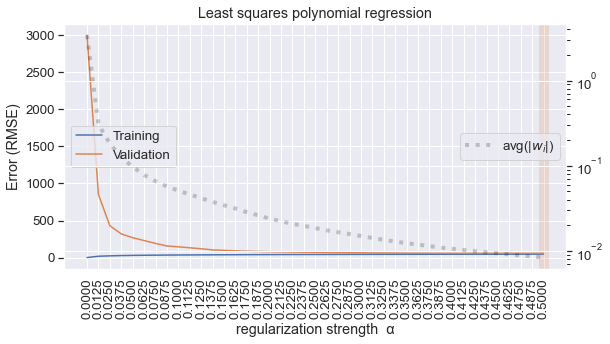

In [169]:
rmse_train_3, rmse_valid_3, avg_coef_3 = [], [], []
for alpha in tqdm(ALPHAS):
    results_3 = make_model(degree = 15, penalty='L1', alpha=alpha).fit(X_train_diabed, y_train_diabed)
    rmse_train_3.append(rmse(results_3.predict(X_train_diabed), y_train_diabed))
    rmse_valid_3.append(rmse(results_3.predict(X_valid_diabed), y_valid_diabed))        
    avg_coef_3.append(        
        # average over CV folds        
        np.mean([            
            np.mean(np.abs(results_3['reg'].coef_))
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train_3, rmse_valid_3,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_3, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

  2%|▏         | 1/41 [00:00<00:32,  1.24it/s]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.588e+04, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
  5%|▍         | 2/41 [02:07<48:44, 74.99s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.974e+03, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
  7%|▋         | 3/41 [04:21<1:04:23, 101.68s/it]C:\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the

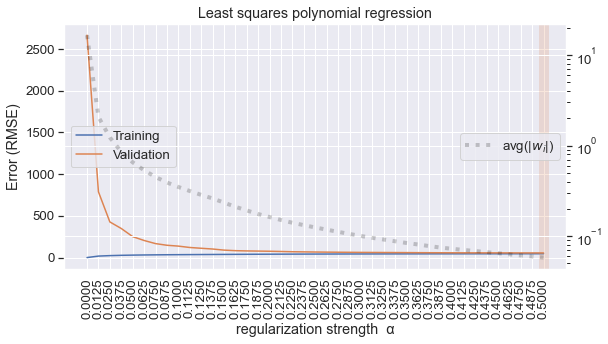

In [329]:
rmse_train_3_d_10, rmse_valid_3_d_10, avg_coef_3_d_10 = [], [], []
count_0_L1 = 0
for alpha in tqdm(ALPHAS):
    results_3_d_10 = make_model(degree = 10, penalty='L1', alpha=alpha).fit(X_train_diabed, y_train_diabed)
    rmse_train_3_d_10.append(rmse(results_3_d_10.predict(X_train_diabed), y_train_diabed))
    rmse_valid_3_d_10.append(rmse(results_3_d_10.predict(X_valid_diabed), y_valid_diabed))        
    avg_coef_3_d_10.append(        
        # average over CV folds        
        np.mean([            
            np.mean(np.abs(results_3_d_10['reg'].coef_))
        ]))
    if len(results_3_d_10['reg'].coef_) > (len(results_3_d_10['reg'].coef_) - np.count_nonzero(results_3_d_10['reg'].coef_)): 
        count_0_L1 += np.size(results_3_d_10['reg'].coef_) - np.count_nonzero(results_3_d_10['reg'].coef_)
    
plot_fitting_graph(ALPHAS, rmse_train_3_d_10, rmse_valid_3_d_10,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_3_d_10, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

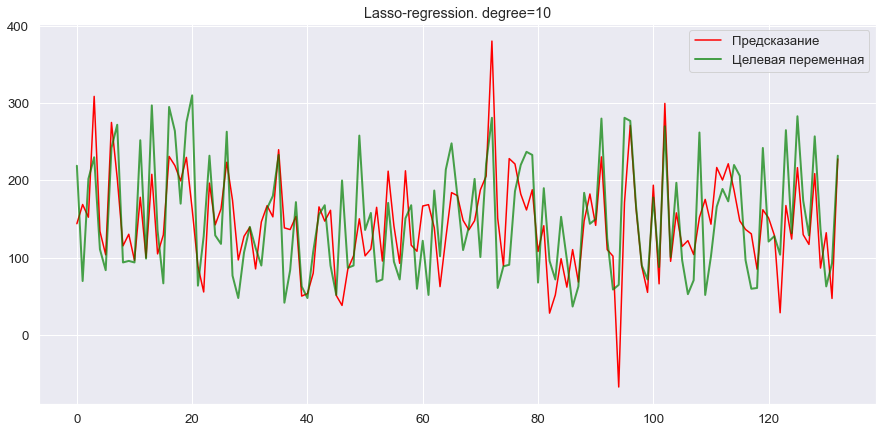

In [170]:
plt.figure(figsize=(15, 7))
plt.plot(results_3.predict(X_valid_diabed), c='red', label='Предсказание') 
plt.plot(y_valid_diabed.to_numpy(), c='green', alpha=0.7, lw=2, label='Целевая переменная')
plt.legend(loc='best')
plt.title('Lasso-regression. degree=10')

plt.show()

In [336]:
outp_3 = results_3_d_10['reg'].coef_
display(np.size(outp_3)) # 8007 весовых коэффициентов 
display(np.count_nonzero(outp_3)) # 100 ненулевых весов


8007

100

In [337]:
outp_3_1 = abs(results_3_d_10['reg'].coef_).min() # 0.0 есть нулевые веса
outp_3_1

0.0

In [338]:
display(count_0_L1) # 314261 - количество нулевых весов во всех 41-й модели с разными коэффициентами регуляризации
np.size(results_3_d_10['reg'].coef_) - np.count_nonzero(results_3_d_10['reg'].coef_) # 7907 - количество нулевых коэффициентов в последней модели

314261

7907

In [280]:
avg_coef_3_d_10

[16.65853984320696,
 2.0784357601593384,
 1.2300293609415627,
 0.8525065327794131,
 0.6532245065712867,
 0.5330872271135779,
 0.4493767814057152,
 0.3905252232790127,
 0.3484259170618642,
 0.314383111664265,
 0.2849039070225772,
 0.26019995263861184,
 0.23390179894653215,
 0.21012516498842854,
 0.19149208250183097,
 0.17473034805614157,
 0.16184063427690284,
 0.15016632660655105,
 0.13986305102023072,
 0.1317088393865083,
 0.12411444351837204,
 0.1174146035004621,
 0.11106794126709894,
 0.10522404051328005,
 0.09986210293702527,
 0.09534555460638998,
 0.09120319354051869,
 0.0873212208260273,
 0.08357654788513665,
 0.08046927109647871,
 0.07721157993085315,
 0.07429626511037785,
 0.07206687111792429,
 0.0699945118222969,
 0.06809737444871385,
 0.06616501249905693,
 0.06442755404899417,
 0.06259655293744751,
 0.060865420339286186,
 0.05928397065829662,
 0.057678982540748165]

#### L2

100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


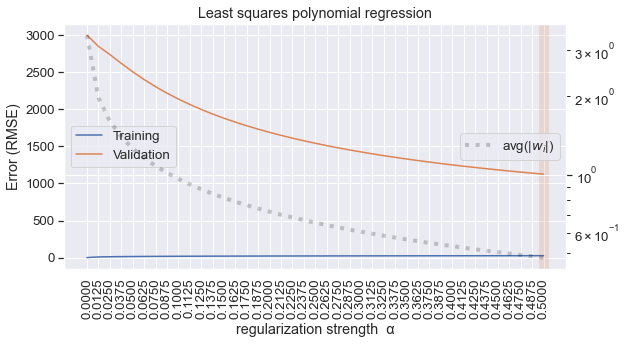

In [324]:
## your code
rmse_train_3_L2, rmse_valid_3_L2, avg_coef_3_L2 = [], [], []
count_0_L2 = 0
for alpha in tqdm(ALPHAS):
    results_3_L2 = make_model(degree = 15, penalty='L2', alpha=alpha).fit(X_train_diabed, y_train_diabed)
    rmse_train_3_L2.append(rmse(results_3_L2.predict(X_train_diabed), y_train_diabed))
    rmse_valid_3_L2.append(rmse(results_3_L2.predict(X_valid_diabed), y_valid_diabed))       
    avg_coef_3_L2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(results_3_L2['reg'].coef_))
            
        ]))
    if len(results_3_L2['reg'].coef_) > (len(results_3_L2['reg'].coef_) - np.count_nonzero(results_3_L2['reg'].coef_)): 
        count_0_L2 += np.size(results_3_L2['reg'].coef_) - np.count_nonzero(results_3_L2['reg'].coef_)
    
plot_fitting_graph(ALPHAS, rmse_train_3_L2, rmse_valid_3_L2,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_3_L2, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

In [339]:
results_3_L2['reg'].coef_

array([[ 42.93968274,   9.71359541, -17.84583067, ...,   1.58707205,
          4.07346674,   5.70862696]])

In [340]:
display(count_0_L2) # 0  - нет нулевых весов

0

In [341]:
display(results_3_L2['reg'].coef_)

array([[ 42.93968274,   9.71359541, -17.84583067, ...,   1.58707205,
          4.07346674,   5.70862696]])

In [342]:
display(abs(results_3_L2['reg'].coef_).min()) # 7.0230555060391e-07 минимальный вес в последней модели при alpha=0,5 т.е нулевых весов нет

7.0230555060391e-07

In [221]:
print(avg_coef_3_L2)

[3.4100642022976975, 1.9662781962896285, 1.5985907033072089, 1.3948133846412598, 1.25776282694442, 1.157578217154548, 1.0794467364937597, 1.0159653506414206, 0.9630431865837672, 0.9180276830887444, 0.8791141376991283, 0.8450482807509114, 0.814935267794474, 0.7879393264720814, 0.7635793112620118, 0.7414917110807243, 0.7212724166630082, 0.7026988712813372, 0.6855651542052101, 0.6696879092291643, 0.6549352374429462, 0.6412044376410622, 0.628356472788582, 0.6162865641329401, 0.6049145095089454, 0.5941754029294704, 0.5840174334629108, 0.5743828326015256, 0.5652222015358469, 0.5564930439735593, 0.5481792374454224, 0.540251001572969, 0.5326634908190369, 0.5253915643349096, 0.5184145922957052, 0.5117213698300757, 0.5052974489475908, 0.4991154246869214, 0.49315407986746246, 0.48740923472077047, 0.48187217425589324]


#### Summary

* В Lasso-регрессии увеличиение коэффициента L1 быстрее приводит к нулевым весам в полиноминальной регрессии. Среднее значение весов приближается к 0-м значениям, а абсолютные значения весовых коэффициентов признаков в подавляющем большинстве становятся равным нулю, что исключает их из прогноза.
* При использовании гребневой регрессии увеличиение коэффициента L2 так же уменьшает веса до значений близких к 0, но они не принимают нулевых знаений.
* Вес признака равный нулю, говорит о отом, что данный признак не будет использоваться в прогнозе. Таким образом регрессия Лассо может исключить из участия в прогнозе ряд признаков которые бесполезны.

In [33]:
# your findings/conclusions

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [90]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


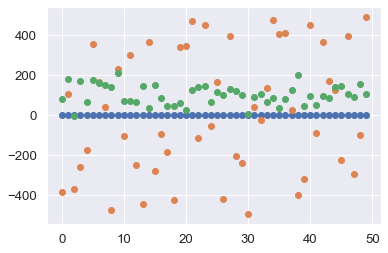

In [130]:
plt.plot(X_hw, 'o')


Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


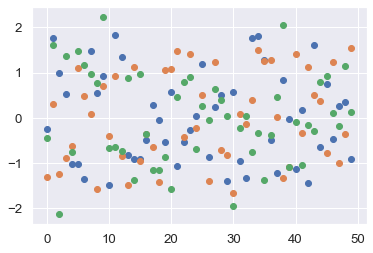

In [354]:
scaler = StandardScaler()
scaler.fit(X_hw)
X_hw_st = scaler.transform(X_hw)

for i in range(X_hw_st.shape[1]):
    print(f'Min of feature {i}: {min(X_hw_st[:, i]):.2f}, max: {max(X_hw_st[:, i]):.2f}')

plt.plot(X_hw_st, 'o')

#### L1

100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


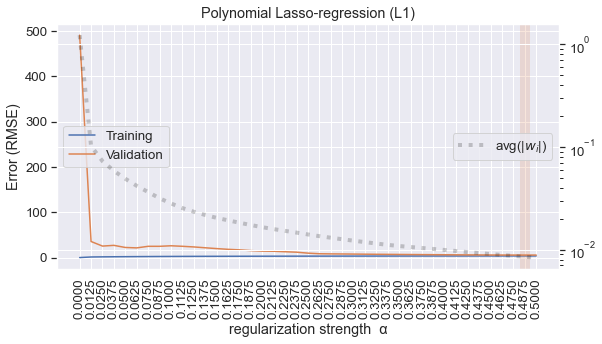

In [345]:
## your code
rmse_train_4_L1, rmse_valid_4_L1, avg_coef_4_L1 = [], [], []
for alpha in tqdm(ALPHAS):
    results_4_L1 = cross_validate(make_model(degree = 15, penalty='L1', alpha=alpha),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_4_L1.append(-np.mean(results_4_L1['train_score']))
    rmse_valid_4_L1.append(-np.mean(results_4_L1['test_score']))        
    avg_coef_4_L1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results_4_L1['estimator']
        ]))


    
plot_fitting_graph(ALPHAS, rmse_train_4_L1, rmse_valid_4_L1,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_4_L1, custom_label='avg(|$w_i$|)',
                   title='Polynomial Lasso-regression (L1)')

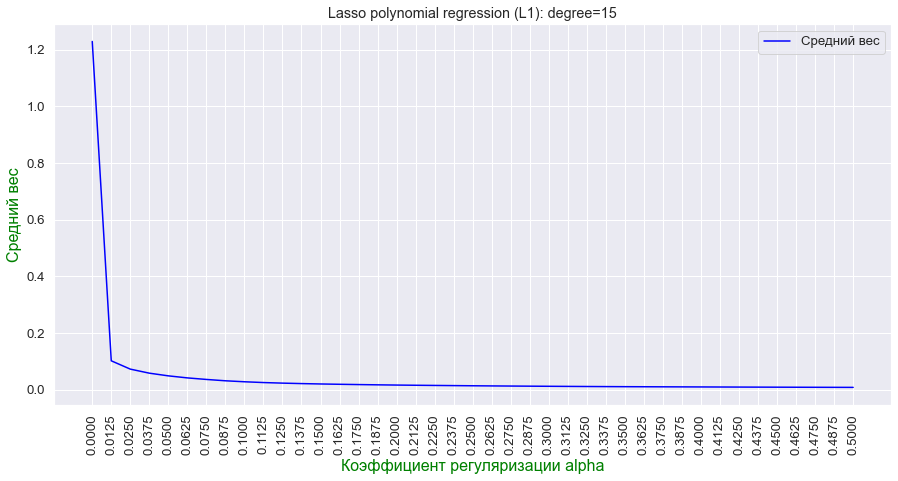

In [346]:
plt.figure(figsize=(15, 7))
plt.plot(ALPHAS, avg_coef_4_L1, c='blue', label='Средний вес')
plt.xticks(ALPHAS, rotation='vertical')
plt.xlabel('Коэффициент регуляризации alpha', fontsize=16, color='green')
plt.ylabel('Средний вес', fontsize=16, color='green')
plt.legend(loc='best')
plt.title(f'Lasso polynomial regression (L1): degree=15')
plt.show()

100%|██████████| 41/41 [00:25<00:00,  1.63it/s]


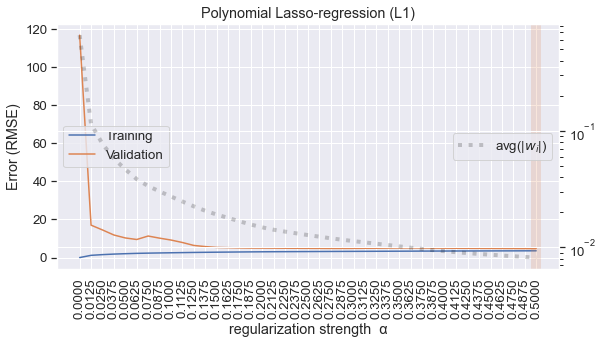

In [347]:
## your code
rmse_train_4_L1, rmse_valid_4_L1, avg_coef_4_L1 = [], [], []
for alpha in tqdm(ALPHAS):
    results_4_L1 = cross_validate(make_model(degree = 15, penalty='L1', alpha=alpha),
                             X_hw_st, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_4_L1.append(-np.mean(results_4_L1['train_score']))
    rmse_valid_4_L1.append(-np.mean(results_4_L1['test_score']))        
    avg_coef_4_L1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results_4_L1['estimator']
        ]))


    
plot_fitting_graph(ALPHAS, rmse_train_4_L1, rmse_valid_4_L1,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_4_L1, custom_label='avg(|$w_i$|)',
                   title='Polynomial Lasso-regression (L1)')

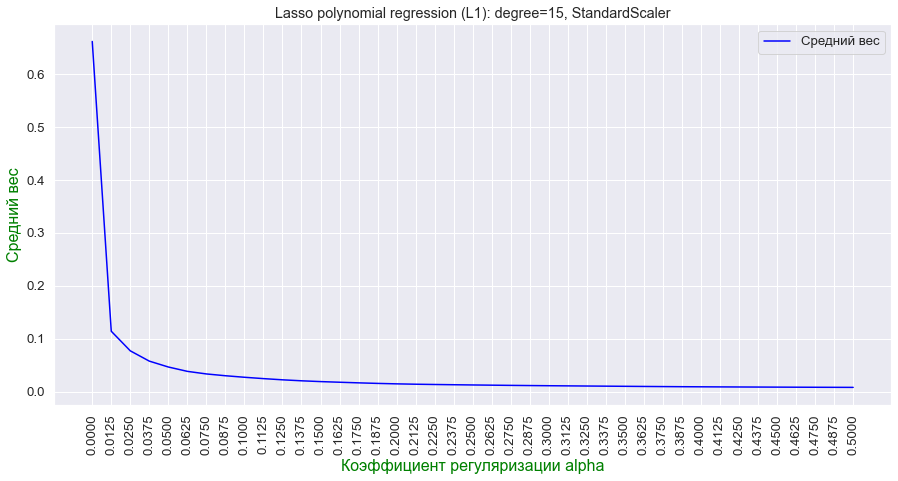

In [349]:
plt.figure(figsize=(15, 7))
plt.plot(ALPHAS, avg_coef_4_L1, c='blue', label='Средний вес')
plt.xticks(ALPHAS, rotation='vertical')
plt.xlabel('Коэффициент регуляризации alpha', fontsize=16, color='green')
plt.ylabel('Средний вес', fontsize=16, color='green')
plt.legend(loc='best')
plt.title(f'Lasso polynomial regression (L1): degree=15, StandardScaler')
plt.show()

#### L2

100%|██████████| 41/41 [00:03<00:00, 12.63it/s]


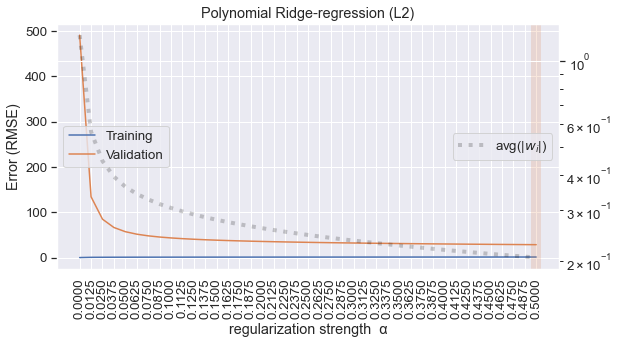

In [350]:
rmse_train_4_L2, rmse_valid_4_L2, avg_coef_4_L2 = [], [], []
for alpha in tqdm(ALPHAS):
    results_4_L2 = cross_validate(make_model(degree = 15, penalty='L2', alpha=alpha),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_4_L2.append(-np.mean(results_4_L2['train_score']))
    rmse_valid_4_L2.append(-np.mean(results_4_L2['test_score']))        
    avg_coef_4_L2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results_4_L2['estimator']
        ]))


    
plot_fitting_graph(ALPHAS, rmse_train_4_L2, rmse_valid_4_L2,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_4_L2, custom_label='avg(|$w_i$|)',
                   title='Polynomial Ridge-regression (L2)')

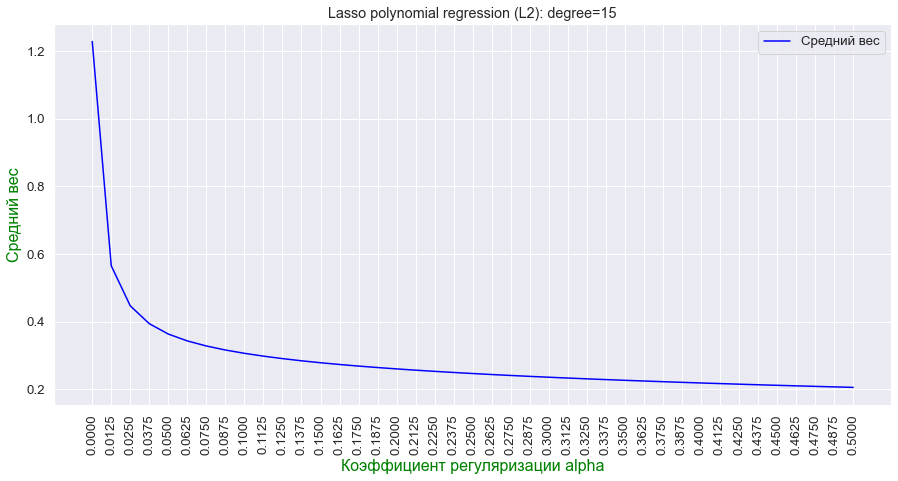

In [351]:
plt.figure(figsize=(15, 7))
plt.plot(ALPHAS, avg_coef_4_L2, c='blue', label='Средний вес')
plt.xticks(ALPHAS, rotation='vertical')
plt.xlabel('Коэффициент регуляризации alpha', fontsize=16, color='green')
plt.ylabel('Средний вес', fontsize=16, color='green')
plt.legend(loc='best')
plt.title(f'Lasso polynomial regression (L2): degree=15')
plt.show()

100%|██████████| 41/41 [00:01<00:00, 21.98it/s]


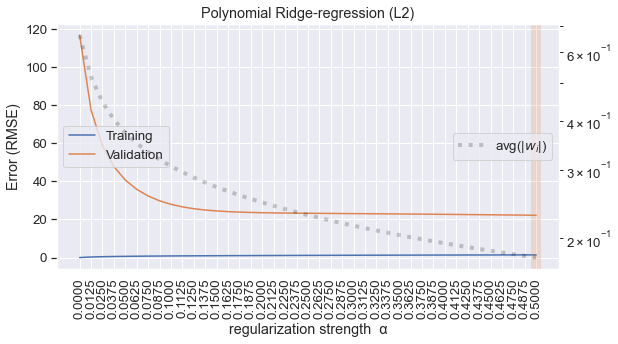

In [352]:
rmse_train_4_L2, rmse_valid_4_L2, avg_coef_4_L2 = [], [], []
for alpha in tqdm(ALPHAS):
    results_4_L2 = cross_validate(make_model(degree = 15, penalty='L2', alpha=alpha),
                             X_hw_st, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_4_L2.append(-np.mean(results_4_L2['train_score']))
    rmse_valid_4_L2.append(-np.mean(results_4_L2['test_score']))        
    avg_coef_4_L2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results_4_L2['estimator']
        ]))


    
plot_fitting_graph(ALPHAS, rmse_train_4_L2, rmse_valid_4_L2,
                   xlabel='regularization strength  α', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_4_L2, custom_label='avg(|$w_i$|)',
                   title='Polynomial Ridge-regression (L2)')

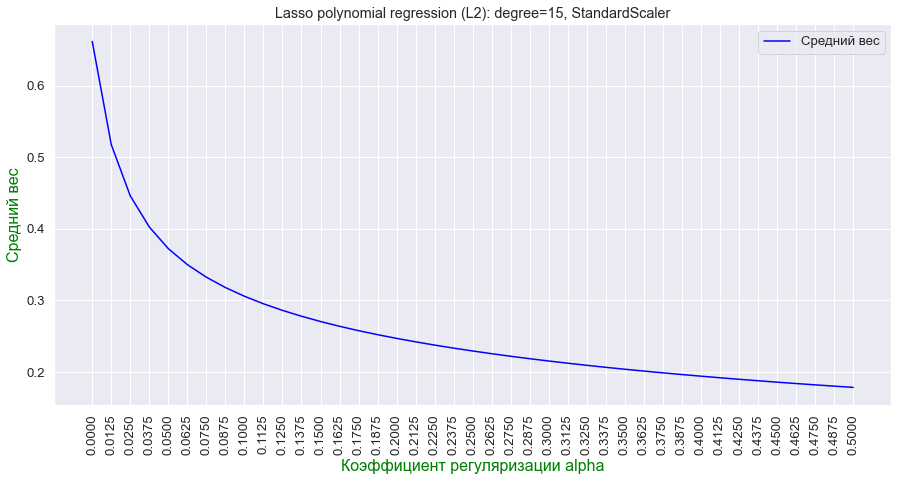

In [353]:
plt.figure(figsize=(15, 7))
plt.plot(ALPHAS, avg_coef_4_L2, c='blue', label='Средний вес')
plt.xticks(ALPHAS, rotation='vertical')
plt.xlabel('Коэффициент регуляризации alpha', fontsize=16, color='green')
plt.ylabel('Средний вес', fontsize=16, color='green')
plt.legend(loc='best')
plt.title(f'Lasso polynomial regression (L2): degree=15, StandardScaler')
plt.show()

#### Summary



* Мы применили масштабирование данных с ипользованием класса StandardScaler. Масштабирование позволяет привести данные к одной размерности. При решении данной задачи результат примерно одинаковый. Насколько это было необходимо ответ неочевиден. 
* Начальная ошибка больше на предварительно необработанных данных, но с увеличением коэффициента регуляризации ошибка становится примерно одинаковой. 
* Тоже происходит и с весовыми коэффициентами: без масштабирования с малыми alpha веса заметно больше, с увеличением коэф. регуляризации заначения весовых коэффициентов уменьшается  с масштабированием меньше.

In [37]:
## your observations/conclusions